# Detroit Blight
*Pranav Shah & Ranjit Konjeti*

url: https://notebooks.azure.com/n/hG8SmHnSBHc/notebooks/DetroitBlightReport.ipynb

## Introduction

A blighted building is a property that has been abandoned, deteriorated, and/or unsafe to the public. Many buildings of this state leads to urban decay - where an otherwise functioning area becomes non-functional or dysfunctional.  
Blighted buildings have been a well documented issue in the Detroit area. If blighted buildings could be predicted before they happen and spreads broadly, government officials could step into provide funding or solutions to prevent or slow down the decay. 

In the following analysis, we'll examine crime, demolition, 311 incidents, and blight violations in the Detroit muncipal area and attempt to predict blight. More specifically, we'll ask does criminal, demolition, and 311 incidents at specific GPS locations in 2016 predict blight violations in those same locations YTD 2017? If so, what is the accuracy and performance of the model. To perform this analysis, we'll join several datasets from Open Data site www.data.detroitmi.gov and run a few models on the final dataset.

## Data Preparation and Working Dataset

One of the main challenges with this project was obtaining, cleaning, and merging the data from four different data repositories. The following section summaraizes the steps we took to prepare the data for exploration and model construction, but this section won't provide cleaning details. While these steps are important and necessary to perform the analysis, a lengthy discussion isn't needed to inform the analysis and conclusions. Specific details and supporting code are discussed in the Appendix. If you wish to execute the code in this notebook from scratch, please start with the Appendix - Data Cleaning section. Here we'll show the final product of the data preparation (i.e. the final working dataset).


In [1]:
# load enviornment variables for analysis. This shorcuts the data prep steps in the Appendix
load("~/Dropbox/UW_DS/DS450_DetroitBlight/envDataPS.RData")

The working data set - detAll contains 71 variables and 144820 unique gps locations in Detroit. The criminal offense and 311 issue type factors are stretched out to individual columns with frequencies of each type at a specific location. The blight violation count, neighborhood, and any demolition permit data is also included with the unique location. The total counts in each of the four groups are represented with an n+"group" variable name.

In [2]:
# Examine structure of final data
str(detAll)

'data.frame':	148820 obs. of  72 variables:
 $ loc.id                             : chr  "400984831213" "414841818" "4173583529" "417938866098" ...
 $ lat                                : num  40.1 41.5 41.7 41.8 41.9 ...
 $ long                               : num  -83.1 -81.8 -83.5 -86.6 -83.4 ...
 $ n                                  : num  1 1 1 1 1 1 1 1 1 1 ...
 $ Abandoned Vehicle                  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Blocked Catch Basin                : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Curbside Solid Waste Issue         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Dead Animal Removal                : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Debris Removal                     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Detroit Land Bank Referral         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Fire Hydrant Issue                 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Illegal Dump Sites                 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Manhole Cover Issue                : num  0 0 0 0 0 0 0 0 0 0 ...
 $ New LE

In [3]:
# summary stats for detAll
summary(detAll)

    loc.id               lat             long              n          
 Length:148820      Min.   :40.10   Min.   :-86.61   Min.   :  1.000  
 Class :character   1st Qu.:42.36   1st Qu.:-83.20   1st Qu.:  1.000  
 Mode  :character   Median :42.39   Median :-83.12   Median :  1.000  
                    Mean   :42.39   Mean   :-83.11   Mean   :  1.283  
                    3rd Qu.:42.42   3rd Qu.:-83.03   3rd Qu.:  1.000  
                    Max.   :42.96   Max.   :-81.80   Max.   :318.000  
                                                                      
 Abandoned Vehicle   Blocked Catch Basin Curbside Solid Waste Issue
 Min.   : 0.000000   Min.   :0.0000      Min.   : 0.00000          
 1st Qu.: 0.000000   1st Qu.:0.0000      1st Qu.: 0.00000          
 Median : 0.000000   Median :0.0000      Median : 0.00000          
 Mean   : 0.007378   Mean   :0.0209      Mean   : 0.03953          
 3rd Qu.: 0.000000   3rd Qu.:0.0000      3rd Qu.: 0.00000          
 Max.   :26.000000   Max

## Data Exploration

The first thing that we want understand the relationship between location and frequencies of incidents and if we see any visual trends we can see. Note, the code below executes a raster plot overlayed on a map file. Due to updates with ggplot2 this code didn't work in jupyter on OSx where this report is written, but did work in Windows where some analysis was conducted. Luckily we saved an image from the work done while operating in windows and is included here as an attachment, but not the output of running the specific cell. Also, only relevant visuals are shown here, rather than all exploraratory attempts.

In [6]:
# Add column for demolition count
library(dplyr)
detAll <- detAll %>% mutate(nDemo = ifelse(commercial != "unknown", 1, 0))

In [7]:
# get google map
library(ggplot2)
library(ggmap)
library(reshape2)
library(gridExtra)

#  citation: 
#  D. Kahle and H. Wickham. ggmap: Spatial Visualization with ggplot2. The R Journal, 5(1), 144-161. URL
#  http://journal.r-project.org/archive/2013-1/kahle-wickham.pdf

centers <- lapply(detAll[, c("lat", "long")], median)
detMap <- get_googlemap(center = c(lon = centers$long, lat = centers$lat), 
                        size = c(640, 640), 
                        scale = 1,
                        zoom = 11,
                        maptype = "roadmap")

# melt frequencies for plotting
melt.detAll <- melt(detAll[, c("lat", "long", "nCrime", "n311", "nDemo", "nBlight")], id = c("lat", "long"))

# plot raster 
# set color ramp
colfunc <- colorRampPalette(c("white", "lightblue", "green", "yellow", "red"))

detMap.den.crime <- ggmap(detMap) + stat_density2d(data = sample_n(melt.detAll %>% filter(variable == "nCrime"), 5000), 
                                                   aes(x = long, y = lat, fill = ..density..),  
                                                   geom = "tile", contour = FALSE, alpha = 0.3) +
                                    scale_fill_gradientn(colours=colfunc(400)) + ggtitle("Criminal Incidents 2016")

detMap.den.311 <- ggmap(detMap) + stat_density2d(data = sample_n(melt.detAll %>% filter(variable == "n311"), 5000), 
                                                 aes(x = long, y = lat, fill = ..density..),  
                                                 geom = "tile", contour = FALSE, alpha = 0.3) +
                                  scale_fill_gradientn(colours=colfunc(400)) + ggtitle("311 Incidents 2016")

detMap.den.demo <- ggmap(detMap) + stat_density2d(data = sample_n(melt.detAll %>% filter(variable == "nDemo"), 5000), 
                                                 aes(x = long, y = lat, fill = ..density..),  
                                                 geom = "tile", contour = FALSE, alpha = 0.3) +
                                    scale_fill_gradientn(colours=colfunc(400)) + ggtitle("Demolitions 2016")

detMap.den.blight <- ggmap(detMap) + stat_density2d(data = sample_n(melt.detAll %>% filter(variable == "nBlight"), 5000), 
                                                  aes(x = long, y = lat, fill = ..density..),  
                                                  geom = "tile", contour = FALSE, alpha = 0.3) +
                                   scale_fill_gradientn(colours=colfunc(400)) + ggtitle("Blight Violations YTD 2017")


# detMap.den.crime
# detMap.den.311
# detMap.den.demo
# detMap.den.blight

grid.arrange(detMap.den.crime, detMap.den.311, detMap.den.demo, detMap.den.blight, nrow = 2, ncol = 2)

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=42.3933,-83.1212&zoom=11&size=640x640&scale=1&maptype=roadmap&sensor=false


ERROR: Error: GeomRasterAnn was built with an incompatible version of ggproto.
Please reinstall the package that provides this extension.


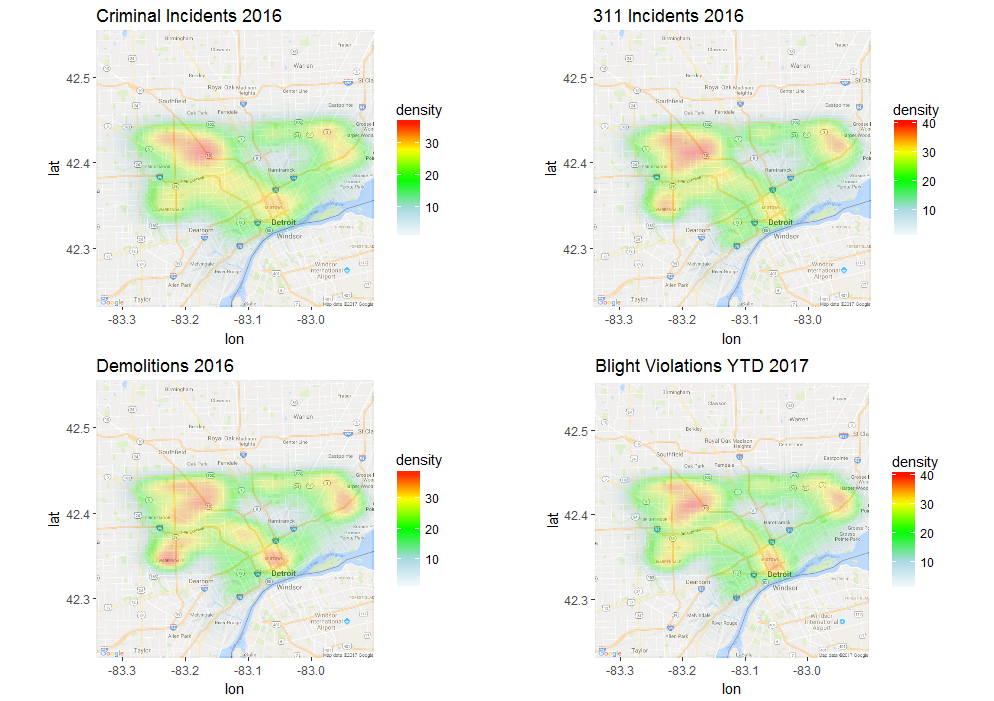

There are several areas in the Detroit area that stand out in this visual. First the northwest and west parts of Detroit had high criminal, 311, and demolition incidents, which overlaps with high 2017 blight violations in the same quadrants of the city. The East and South Central areas show the same. Next we want to understand if there are any correlations between crime, 311 incidents, demolitions and blight violations.


> cor.mtest <- function(mat, ...) {
+     mat <- as.matrix(mat)
+     n <- ncol(mat)
+     p.mat <- matrix(NA, n, n)
+     diag(p.mat) <- 0
+     for  .... [TRUNCATED] 

> cor.mtest.2 <- function(mat, conf.level = 0.95) {
+     mat <- as.matrix(mat)
+     n <- ncol(mat)
+     p.mat <- lowCI.mat <- uppCI.mat <- matrix(N .... [TRUNCATED] 


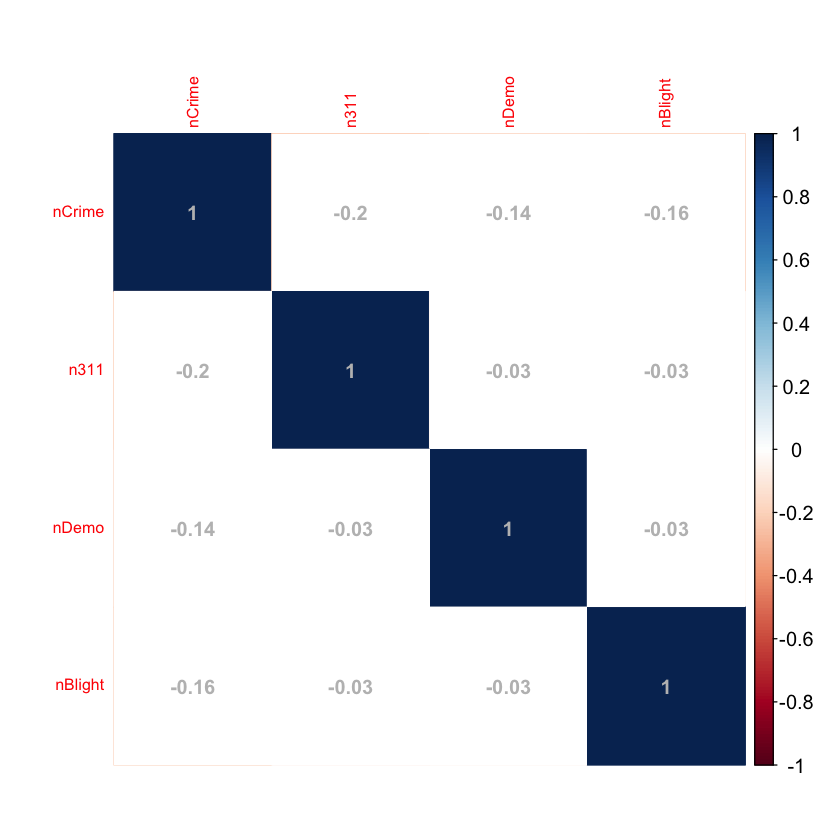

In [8]:
# correlation plot
# is there a correlation between frequency of crime, 311, demos, and blight? 
# There doesn't seem to be much correlation. 

library(corrplot)

cors <- cor(detAll %>% select(nCrime, n311, nDemo, nBlight), method = 'pearson')

source('cormtest.R', echo=TRUE)
corm <- cor.mtest.2(cors)

# add cor.mtest for p.value matrix.... look in help

corrplot(cors,  p.mat = corm[[1]], insig = "blank", method = "color",
         addCoef.col="grey", 
         order = "AOE", tl.cex = 0.8,
         cl.cex = 1/par("cex"), addCoefasPercent = FALSE)

It looks like there are not any significant correlations between the four frequencies.

## Model Construction and Evaluation

In the following section we will look at three models - a baseline logistic classifier, a regularized logistic classifier, and a tree based model (CART). The last two models were cross validated to 10 folds. 

### Baseline logistic on all non-count data

Before running the baseline logistic model, we created a labled column - simply if a location had any blight violations. Next we split the data into a training and testing set. Then we selected the relevant columns we wanted in the model, in this case the offense and issue type categories and demolition data. Because the neighborhood factor was proving complex in the models we left it out (this is likely because many of the neighboorhoods were "unknown"). 

Loading required package: lattice
Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”

[1] "AUC=0.962377037582919"


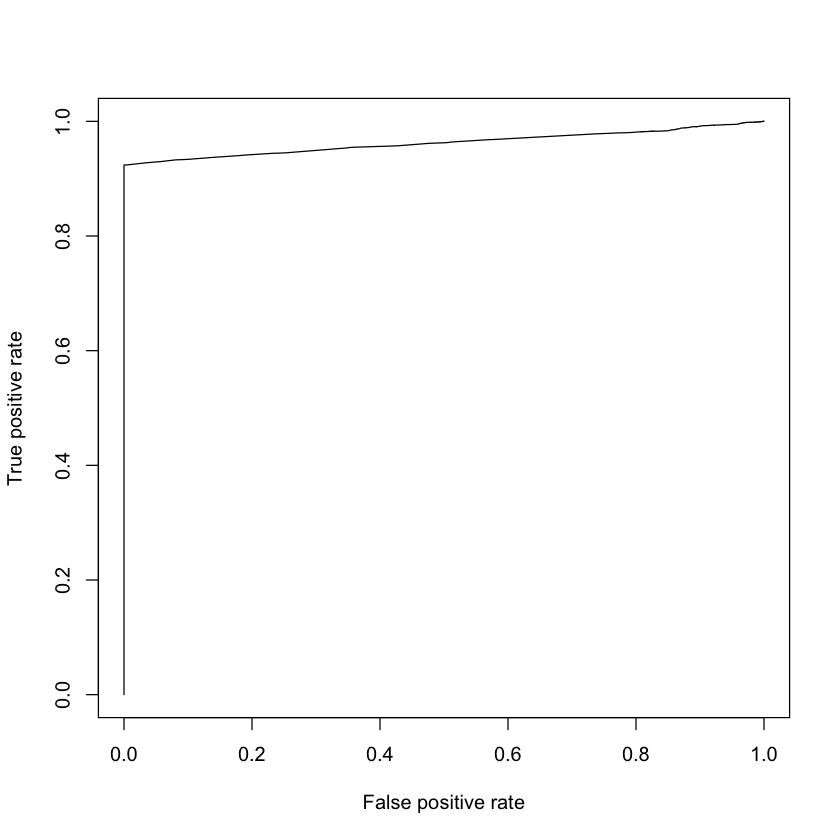

In [9]:
# Build several models and compare performance 
# 1. Add blight classification column
# 2. split data into training and testing set
# 3. Baseline model logistic regression with K-fold cross validation
# 4. CART with K-fold cross validation

library(caret)
library(ROCR)

# add a classification column for blight
detAll$blight <- as.factor(ifelse(detAll$nBlight > 0, "Yes", "No"))

# split data
set.seed(36924)
perc.split <- 0.5
row.samp <- sample(1:nrow(detAll), perc.split*nrow(detAll))
detAll.train <- detAll[row.samp, ]
detAll.test <- detAll[-row.samp, ]

# select data for the model
detAll.train.trim <- detAll.train %>% select(-nCrime, -n311, -nBlight, -n, -loc.id, - lat, -long, -ng.hood)
detAll.test.trim <- detAll.test %>% select(-nCrime, -n311, -nBlight, -n, -loc.id, - lat, -long, -ng.hood)

# baseline regression

logit.base <- glm(blight ~ ., data = detAll.train.trim, family = "binomial")

logit.base.pred <- predict(logit.base, detAll.test.trim %>% select(-blight))
pred <- prediction(as.numeric(logit.base.pred), as.numeric(detAll.test.trim$blight))

prf <- performance(pred, measure = "tpr", x.measure = "fpr")
plot(prf)

auc <- performance(pred, "auc")
print(paste("AUC=", auc@y.values[[1]], sep=""))

In the baseline model we find that the AUC is above 0.96, but this is misleading as the model seems to be rank deficient. Or the predictor variable data doesn't seem to be doing a good job of reliably predicting blight at specific locations. This is an issue we will see in other models. 

### Regularized Logistic with 10-fold CV

Next we try a logistic classifier with L1 and L2 penalization. Once again we see some issues with this model in that the accuracy measure AUC is high, but seems too good to be true. 

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-10



[1] "AUC=0.961927146739692"


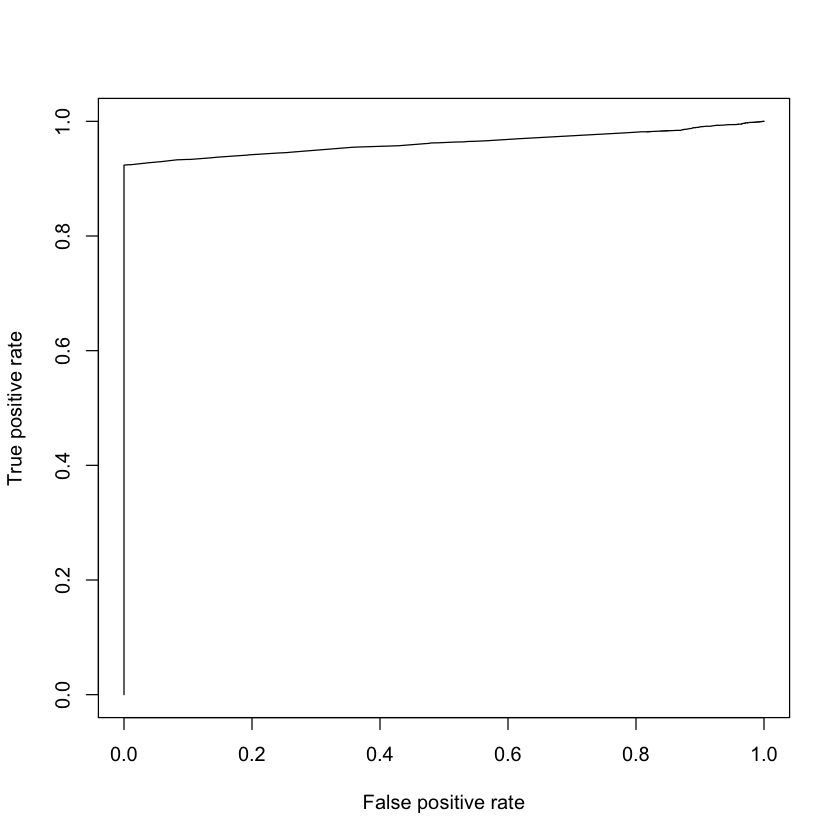

In [11]:
# k fold glmnet logistic, with constant L1 nad L2
library(glmnet)
# create model matrix
mod.train <- model.matrix(blight ~ . -1, data = detAll.train.trim)
# setup glmnet with alpha = 0.5 and nlambda =20
logit.reg <- cv.glmnet(mod.train, detAll.train.trim$blight, nfolds = 10, family = "binomial", nlambda = 20, alpha = 0.5)

logit.reg.pred <- predict(logit.reg, model.matrix(blight ~. -1, detAll.test.trim))
pred <- prediction(as.numeric(logit.reg.pred), as.numeric(detAll.test.trim$blight))

prf <- performance(pred, measure = "tpr", x.measure = "fpr")
plot(prf)

auc <- performance(pred, "auc")
print(paste("AUC=", auc@y.values[[1]], sep=""))

### CART - Tree based model

Again we will use 10 fold cross validation but with an regression tree for this model. After several tests we control the max depth of the tree to 10 branches. This model predicts as good as a guess with an AUC of 0.5. 

n= 74410 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

1) root 74410 4734 No (0.93637952 0.06362048) *


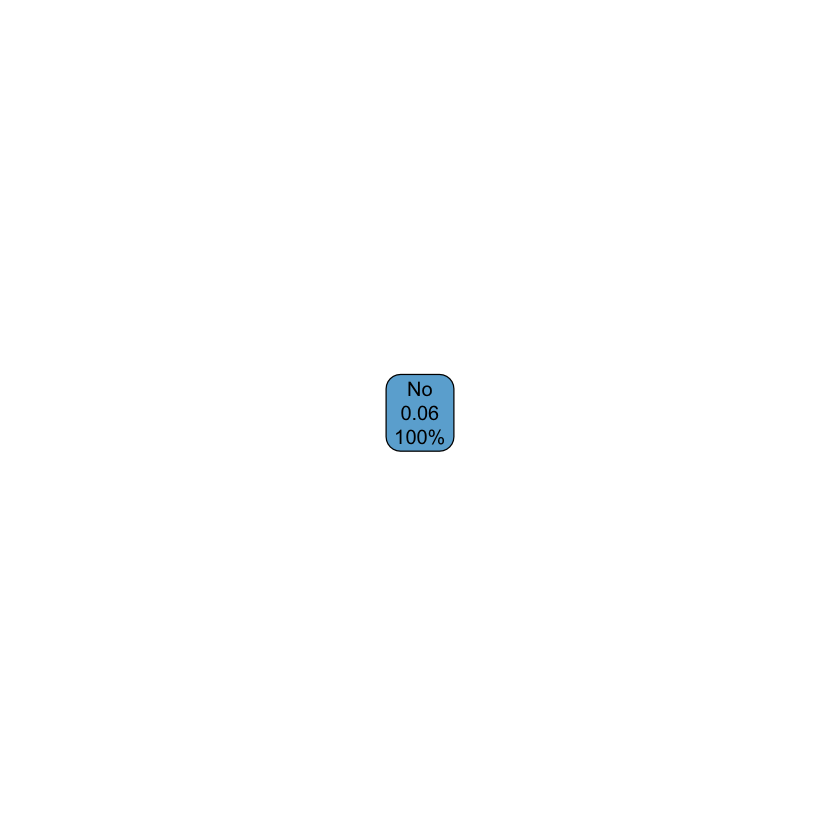

In [12]:
# regression tree
library(rpart)
library(rpart.plot)

fitControl <- trainControl(## 5-fold CV
                            method = "cv",
                            number = 10,
                            classProbs = TRUE,
                            summaryFunction = twoClassSummary)

rpart.model <- train(x = detAll.train.trim[, 1:65],
                     y = detAll.train.trim[, 66],
                     method = "rpart1SE",
                     trControl = fitControl,
                     control = rpart.control(maxdepth = 10),
                     metric = "ROC")

print(rpart.model$finalModel)
rpart.plot(rpart.model$finalModel)

[1] "AUC=0.5"


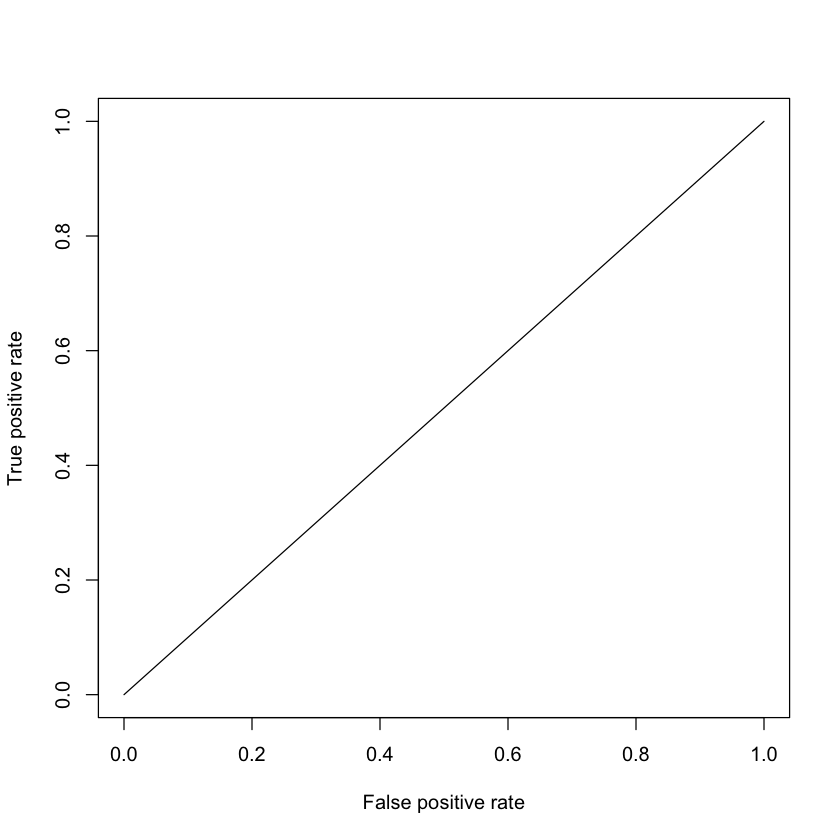

In [13]:
rpart.pred <- predict(rpart.model$finalModel, detAll.test.trim %>% select(-blight))
pred <- prediction(as.numeric(rpart.pred[,2]), as.numeric(detAll.test.trim$blight))

prf <- performance(pred, measure = "tpr", x.measure = "fpr")
plot(prf)

auc <- performance(pred, "auc")
print(paste("AUC=", auc@y.values[[1]], sep=""))

#### Adjustments to CART with nCount data

Because we are not seeing reliable prediction with the above models we can try using n+"groupings" features in the tree. Even using just the count data, we see some too good to be true results - an AUC of 0.96. This suggests that the features we've created and are using in the models are not really predicting anything. Additionally, blight violations only make up 6% of the observations in the working data set, so the dataset may suffer from minority imbalance and SMOTEing or another sampling method may be required. 

[1] "AUC=0.964477068048075"


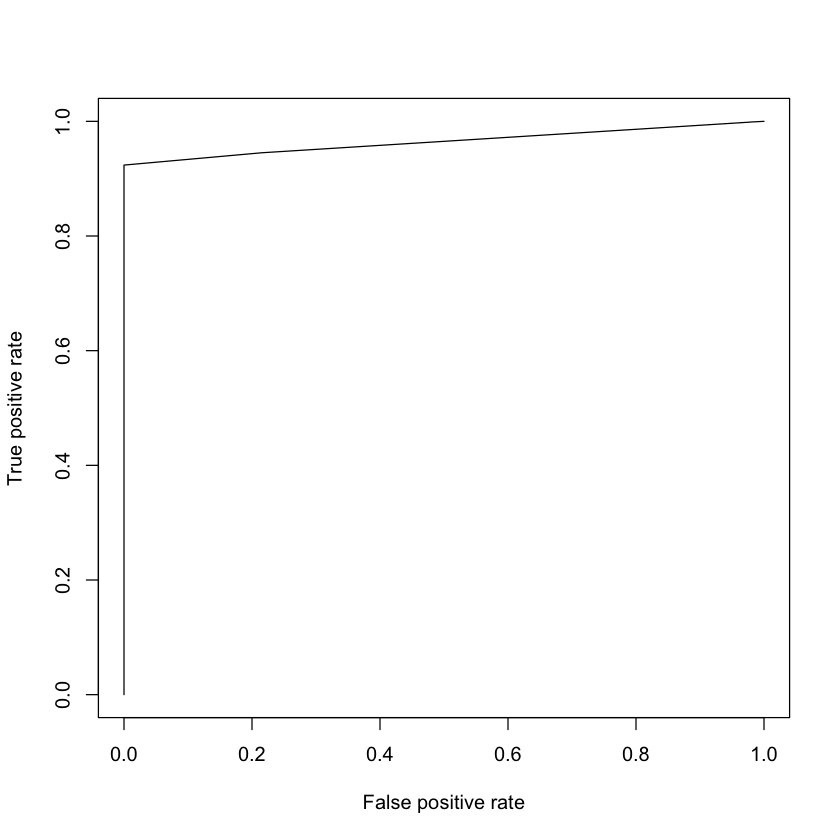

In [14]:
# select data for the model
detAll.train.trim <- detAll.train %>% select(nCrime, n311, d.price, blight)
detAll.test.trim <- detAll.test %>% select(nCrime, n311, d.price, blight)

#setup control
fitControl <- trainControl(## 10-fold CV
  method = "cv",
  number = 10,
  classProbs = TRUE,
  summaryFunction = twoClassSummary)

#run rpart
rpart.model <- train(x = detAll.train.trim[, 1:3],
                     y = detAll.train.trim[, 4],
                     method = "rpart1SE",
                     trControl = fitControl,
                     control = rpart.control(maxdepth = 10),
                     metric = "ROC")

# predict and evaluate AUC on test set
rpart.pred <- predict(rpart.model$finalModel, detAll.test.trim %>% select(-blight))
pred <- prediction(as.numeric(rpart.pred[,2]), as.numeric(detAll.test.trim$blight))

prf <- performance(pred, measure = "tpr", x.measure = "fpr")
plot(prf)

auc <- performance(pred, "auc")
print(paste("AUC=", auc@y.values[[1]], sep=""))

n= 74410 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 74410 4734 No (0.936379519 0.063620481)  
   2) nCrime>=0.5 53235  249 No (0.995322626 0.004677374) *
   3) nCrime< 0.5 21175 4485 No (0.788193625 0.211806375)  
     6) n311>=0.5 15200  100 No (0.993421053 0.006578947) *
     7) n311< 0.5 5975 1590 Yes (0.266108787 0.733891213)  
      14) d.price>=2008 1596    6 No (0.996240602 0.003759398) *
      15) d.price< 2008 4379    0 Yes (0.000000000 1.000000000) *


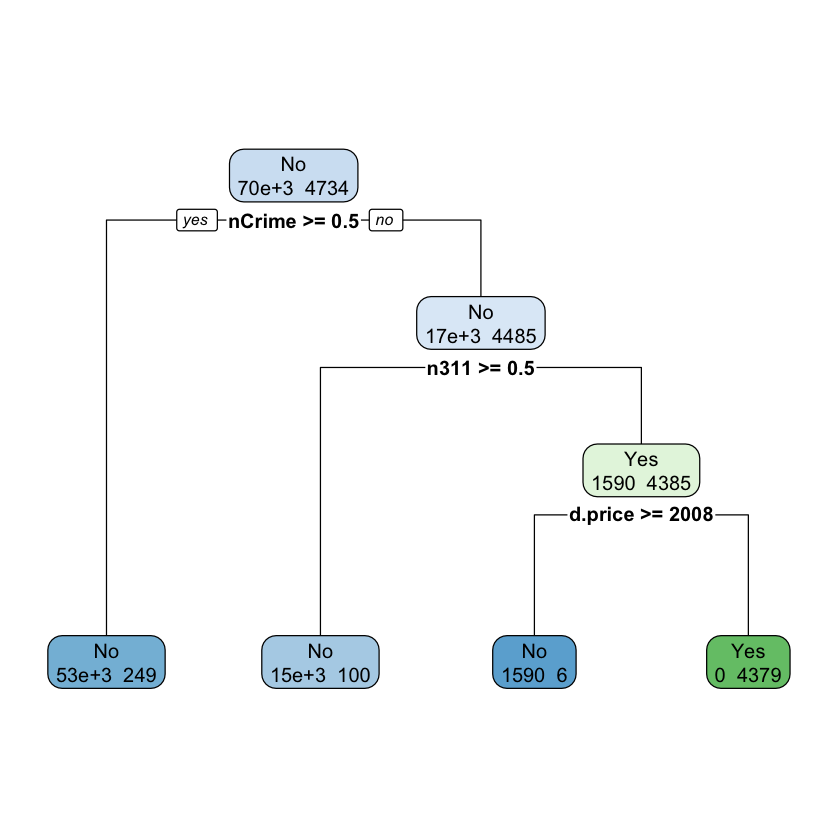

In [16]:
# print and plot tree
print(rpart.model$finalModel)
rpart.plot(rpart.model$finalModel,  extra = 1)

In [17]:
# blight count
summary(detAll$blight)

No    Yes 
139316   9504

## Conclusions

Based on the map visual, we can definitely see some areas on the map that have high crime, 311 incidents, and demos that overlap with blight violations. Unfortunately the dataset with the mostly frequency features don't really do a good job of predicting blight. The models seem to be rank defecient, meaning the data we are using to predict blight in the following year doesn't have enough strong information to create a good model. Some reasons for this include:

- Location resolution is to fine and may need to expanded to a greater radius. In our analysis, locations were rounded to a 1e-4 resolution. 
- There may be a minority imbalance. Another sampling method to correct this imbalance may be required for better model results. 
- Predicting blight in the following year (i.e. 2016 incidents predicting 2017 blight) isn't the right question. Potential looking at shorter time frames (next month(s)) or overlapping time frames (within the same quarter) may produce better results. 



## Appendix - Data Cleaning and Preparation

### Get Data
 
We obtained data from Detroit's open source data repository. 

In [ ]:
# Get Detroit Map Data
# download csvs from https://data.detroitmi.gov/

# Note this takes a long time...

# Detroit crime data from Dec 6th 2016 to present
detCrime1216_pres <- read.csv("https://data.detroitmi.gov/api/views/6gdg-y3kf/rows.csv?accessType=DOWNLOAD")

# Detroit crime data from Jan 1, 2009 to Dec 6th 2016
detCrime1909_1216 <- read.csv("https://data.detroitmi.gov/api/views/invm-th67/rows.csv?accessType=DOWNLOAD&bom=true&format=true")

# 311 issues submission from Dec 3rd 2014 to present
det311 <- read.csv("https://data.detroitmi.gov/api/views/fwz3-w3yn/rows.csv?accessType=DOWNLOAD")

# Demolition permits from Jan 1st 2014 to present
detDemolitions <- read.csv("https://data.detroitmi.gov/api/views/rv44-e9di/rows.csv?accessType=DOWNLOAD")

# Blight violations (tickets) from 2006 - present
detBlight <- read.csv("https://data.detroitmi.gov/api/views/ti6p-wcg4/rows.csv?accessType=DOWNLOAD")


### Initial Summary of Raw Data Objects

Here we look at the raw data obtained from Detroit's website.

In [ ]:
# Source getDetroitData
# source("getDetroitData.r") #run this to get data

# intitial summary of data - 311 issues
head(det311)
str(det311)
summary(det311)

# initial summary of data - Crime
head(detCrime1216_pres)
str(detCrime1216_pres)
summary(detCrime1216_pres)

# initial summary of data - Crime pre 12/6/16
head(detCrime1909_1216)
str(detCrime1909_1216)
summary(detCrime1909_1216)

# initial summary of data - Demolitions
head(detDemolitions)
str(detDemolitions)
summary(detDemolitions)

# initial summary of data - Blight
head(detBlight)
str(detBlight)
summary(detBlight)

### Clean Data

In this step we: 
1. Filter raw data in criminal, demolitions, and 311 incidents to dates between 1/1/16 to 12/31/16. Note Criminal activity only goes to 12/6/16, because of a system change to Detroit's data collection process. Criminal data from 12/6/16 to 12/31/16 is not included in the final data set.
2. Filter raw data in Blight to dates between 1/1/17 to YTD 2017 (11/13/17, at the time of coding)
3. Parse GPS location data in criminal data. See gpsParse function.
4. Include only latitude, longitude, criminal offense category, 311 category, neighborhood, commercial building, and demolition price in final data.
5. Omit data NA location data from Blight 
6. Round latitude and longitude to 4 sig figs. 
7. Save raw data to enviornment, if needed later. 

In [ ]:
# The following code is based on the following report: 
# https://rstudio-pubs-static.s3.amazonaws.com/194529_5b7aff21a29541fb94b8f4176e42abf2.html
# by Paulo Cardso

gpsParse <- function(loc.txt, p="\\(.*\\)"){
  r <- regexpr(p, loc.txt)
  out <- rep(NA, length(r))
  out[r != -1] <- regmatches(loc.txt, r)
  out <- gsub("[()]", "", out)
  lat <- unlist(lapply(out, function(x) as.numeric(strsplit(x, split=",")[[1]][1])))
  long <- unlist(lapply(out, function(x) as.numeric(strsplit(x, split=",")[[1]][2])))
  list(lat=lat, long=long)
}

In [ ]:
# clean data
# 1. To limit scope of this activity - filter out incidents that happened before 1.1.17
# 2. Strip out columns that are not necessary for this analysis

# source("getDetroitData.R")

library(dplyr)

# Filter dates > 1/1/17
# Blight violations
detBlightDate <- detBlight
detBlightDate$Violation.Date <- as.Date(detBlightDate$Violation.Date, "%m/%d/%Y")
detBlightDate <- detBlightDate %>% filter(Violation.Date >= '2017-01-01')

# demolitions
detDemDate <- detDemolitions
detDemDate$Demolition.Date <- as.Date(detDemDate$Demolition.Date, "%m/%d/%Y")
detDemDate <- detDemDate %>% filter(Demolition.Date >= '2016-01-01' & Demolition.Date < '2017-01-01')

# 311 incidents
det311Date <- det311
det311Date$ticket_created_date_time <- as.character(det311Date$ticket_created_date_time)
det311Date$ticket_created_date_time <- as.POSIXct(strptime(det311Date$ticket_created_date_time, "%m/%d/%Y %H:%M:%S %p"))
det311Date$ticket_created_date <- as.Date(det311Date$ticket_created_date_time)
det311Date <- det311Date %>% filter(ticket_created_date >= '2016-01-01' & ticket_created_date < '2017-01-01')

# Crime incidents post 12/6/16
detCrimeDate <- detCrime1216_pres
detCrimeDate$Incident.Date...Time <- as.character(detCrimeDate$Incident.Date...Time)
detCrimeDate$Incident.Date...Time <- as.POSIXct(strptime(detCrimeDate$Incident.Date...Time, "%m/%d/%Y %H:%M:%S %p"))
detCrimeDate$Incident.Date <- as.Date(detCrimeDate$Incident.Date...Time)
detCrimeDate <- detCrimeDate %>% filter(Incident.Date >= '2017-01-01')

# Crime incidents pre 12/6/16, note this was added later because once all data was merged
# it was determined that blight violations didn't overlap with crime and 311 locations in 2017...
detCrimeDate <- detCrime1909_1216
detCrimeDate$Incident.Date...Time <- as.character(detCrimeDate$INCIDENTDATE)
detCrimeDate$Incident.Date...Time <- as.POSIXct(strptime(detCrimeDate$Incident.Date...Time, "%m/%d/%Y %H:%M:%S %p"))
detCrimeDate$Incident.Date <- as.Date(detCrimeDate$Incident.Date...Time)
detCrimeDate <- detCrimeDate %>% filter(Incident.Date >= '2016-01-01' & Incident.Date < '2017-01-01')

# Need to string split location in pre 12/6/17 crime data
source("gpsParse.R")
t.loc <- gpsParse(loc.txt = detCrimeDate$LOCATION)
detCrimeDate$Latitude <- t.loc$lat
detCrimeDate$Longitude <- t.loc$long

# Remove columns that are not needed for analysis
dBlight <- detBlightDate %>% select(Violation.Latitude, Violation.Longitude)
dDemo <- detDemDate %>% select(Price, Commercial.Building, Latitude, Longitude)
d311 <- det311Date %>% select(issue_type, lat, lng)
dCrime <- detCrimeDate %>% select(CATEGORY, NEIGHBORHOOD, Latitude, Longitude)

# verify structures
str(dBlight)
str(dDemo)
str(d311)
str(dCrime)

summary(dBlight) # contains NA lats and longs that will need omission.
summary(dDemo)
summary(d311)
summary(dCrime)


# remove date data
rm(det311Date, detBlightDate, detDemDate) #detCrimeDate
# remove origin data -- only do this if sure
rm(detCrime1909_1216, detCrime1216_pres, detDemolitions, detBlight, det311)

# rename columns 
colnames(dBlight) <- c("lat", "long")
colnames(dDemo) <- c("d.price","commercial", "lat", "long")
colnames(d311) <- c("inc.type", "lat", "long")
colnames(dCrime) <- c("crm.type", "ng.hood", "lat", "long")

# round lat long to 4 sig figs
dBlight[,sapply(dBlight, is.numeric)] <- as.data.frame(sapply(dBlight[,sapply(dBlight, is.numeric)], round, digits = 4))
dDemo[,sapply(dDemo, is.numeric)] <- as.data.frame(sapply(dDemo[,sapply(dDemo, is.numeric)], round, digits = 4))
d311[,sapply(d311, is.numeric)] <- as.data.frame(sapply(d311[,sapply(d311, is.numeric)], round, digits = 4))
dCrime[,sapply(dCrime, is.numeric)] <- as.data.frame(sapply(dCrime[,sapply(dCrime, is.numeric)], round, digits = 4))

# omit blight violations without gps lat and long
dBlight <- na.omit(dBlight)

# change dDemo$d.price to numeric
dDemo$d.price <- as.numeric(sub('$', "", as.character(dDemo$d.price), fixed = TRUE))

# remove "DPW - " and " - DPW USE ONLY" from incident factors in d311
a <- gsub("DPW - ", "", as.character(d311$inc.type))
a <- gsub(" - DPW USE ONLY", "", as.character(a))
a <- as.factor(a)
d311$inc.type <- a

# keep raw data from 2016 on
det311.2016 <- det311
det311.2016$ticket_created_date_time <- as.character(det311.2016$ticket_created_date_time)
det311.2016$ticket_created_date_time <- as.POSIXct(strptime(det311.2016$ticket_created_date_time, "%m/%d/%Y %H:%M:%S %p"))
det311.2016$ticket_created_date <- as.Date(det311.2016$ticket_created_date_time)
det311.2016 <- det311.2016 %>% filter(ticket_created_date >= '2016-01-01')

detCrime.2017 <- detCrime1216_pres
detCrime.2017 $Incident.Date...Time <- as.character(detCrime.2017 $Incident.Date...Time)
detCrime.2017 $Incident.Date...Time <- as.POSIXct(strptime(detCrime.2017 $Incident.Date...Time, "%m/%d/%Y %H:%M:%S %p"))
detCrime.2017 $Incident.Date <- as.Date(detCrime.2017 $Incident.Date...Time)
detCrime.2017  <- detCrime.2017  %>% filter(Incident.Date >= '2016-12-01')

detDem.2016 <- detDemolitions
detDem.2016$Demolition.Date <- as.Date(detDem.2016$Demolition.Date, "%m/%d/%Y")
detDem.2016 <- detDem.2016 %>% filter(Demolition.Date >= '2016-01-01')

detBlight.2016 <- detBlight
detBlight.2016$Violation.Date <- as.Date(detBlight.2016$Violation.Date, "%m/%d/%Y")
detBlight.2016 <- detBlight.2016 %>% filter(Violation.Date >= '2016-01-01')


### Mutate Data 

In this set of code we further prepare the data for exploratory and model consumption

In this step we:
1. Create a location charater id column, which we use to join data sets together. 
2. Extend out criminal offense factor to individual columns
3. Extend out 311 issue types to individual columns
4. Get frequencies at specific locations for each data object through location id groupings
5. Create a master list of unique locations
6. Merge the four data files together on unique location character ids
7. Clean up final data set - fill in NAs in numerics and factors 


In [ ]:
# Mutate data
# 1. Add character id column
# 2. Group and count by character id
# 3. Join data sets on id
# 4. Add blight classification on id

# source("cleanData.R")

# add loc character id column for each data set

d311$loc.id <- gsub("[^0-9]", "", paste(d311$lat, d311$long, sep = ""))
dBlight$loc.id <- gsub("[^0-9]", "", paste(dBlight$lat, dBlight$long, sep = ""))
dCrime$loc.id <- gsub("[^0-9]", "", paste(dCrime$lat, dCrime$long, sep = ""))
dDemo$loc.id <- gsub("[^0-9]", "", paste(dDemo$lat, dDemo$long, sep = ""))

# extend out factors to dummy variables for counting

# d311 

library(dummies)
a <- dummy(d311$inc.type, sep = "")
colnames(a) <- gsub("inc.type", "", colnames(a), fixed = TRUE)
d311 <- cbind(d311, a)

# dCrime
a <- dummy(dCrime$crm.type, sep = "")
colnames(a) <- gsub("crm.type", "", colnames(a), fixed = TRUE)
dCrime <- cbind(dCrime, a)

# group columns on location id and sum incidents
temp.gr.311 <- d311[, 4:ncol(d311)] %>% group_by(loc.id) %>% summarise_all(funs(sum))
temp.gr.Crime <- dCrime[, 5:ncol(dCrime)] %>% group_by(loc.id) %>% summarise_all(funs(sum))
temp.gr.Blight <- dBlight %>% group_by(loc.id) %>% summarise(nBlight = n())

# No id grouping results from demo data, consider removing next line (i.e. same as dDemo)
temp.gr.Demo <- dDemo %>% select(loc.id, d.price, commercial) %>% group_by(loc.id) #%>% summarise_all(funs(sum))

# bind frequencies to temps
c <- d311[, 4:ncol(d311)] %>% group_by(loc.id) %>% summarise(n311 = n())
temp.gr.311 <- cbind(temp.gr.311, n311 = c$n311)

c <- dCrime[, 5:ncol(dCrime)] %>% group_by(loc.id) %>% summarise(nCrime = n())
temp.gr.Crime <- cbind(temp.gr.Crime, nCrime = c$nCrime)
                                                                                           
# create master list of unique loc.ids with lat and long from all dfs
unique.loc <- d311 %>% select(loc.id, lat, long)
unique.loc <- rbind(unique.loc, dBlight %>% select(loc.id, lat, long))
unique.loc <- rbind(unique.loc, dCrime %>% select(loc.id, lat, long))
unique.loc <- rbind(unique.loc, dDemo %>% select(loc.id, lat, long))
unique.loc <- unique.loc %>% select(loc.id, lat, long) %>% group_by(loc.id, lat, long) %>% count()

# join all temp dataset columns to unique.loc - master list of unique incident locations.
a <- merge(unique.loc, temp.gr.311, by.x = "loc.id", by.y = "loc.id", all.x = TRUE)
a <- merge(a, temp.gr.Crime, by.x = "loc.id", by.y = "loc.id", all.x = TRUE)
a <- merge(a, temp.gr.Demo, by.x = "loc.id", by.y = "loc.id", all.x = TRUE)
a <- merge(a, temp.gr.Blight, by.x = "loc.id", by.y = "loc.id", all.x = TRUE)

# join neighborhood to locations
d <- dCrime %>% select(ng.hood, loc.id) %>% group_by(ng.hood, loc.id) %>% count()
a <- merge(a, d[, c("ng.hood", "loc.id")], by.x = "loc.id", by.y = "loc.id", all.x = TRUE)
detAll <- a

# clean up final data

# na's in numerics
detAll <- detAll %>% mutate_if(is.numeric, funs(replace(., is.na(.), 0)))

# deal with factors
a <- as.character(detAll$commercial)
a[is.na(a)] <- "unknown"
a <- as.factor(a)
detAll$commercial <- a

a <- as.character(detAll$ng.hood)
a[is.na(a)] <- "unknown"
a <- replace(a, a == "", "unknown")
a <- as.factor(a)
detAll$ng.hood <- a

# add nDemo
detAll <- detAll %>% mutate(nDemo = ifelse(commercial != "unknown", 1, 0))

# remove whacky lats and longs
detAll <- detAll %>% filter(lat <= 100 & lat >= 35)

# rm data that's not needed past this point
rm(a, c, d, a_p, temp.gr.311, temp.gr.Blight, temp.gr.Crime, temp.gr.Demo, unique.loc)
rm(d311, dBlight, dCrime, dDemo)
rm(detCrime1909_1216)
rm(detCrime1216_pres)